In [1]:
import tensorflow as tf

import os
import hickle as hkl
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("../data/train-csv/chm/chm-master.csv")
#df2 = pd.read_csv("../data/train-csv/chm/chm-2019-master.csv")
#df3 = pd.read_csv("../data/train-csv/chm/chm-2018-master.csv")

#df = pd.concat([df1, df2, df3])
df = df[df.mislabel == "No"]

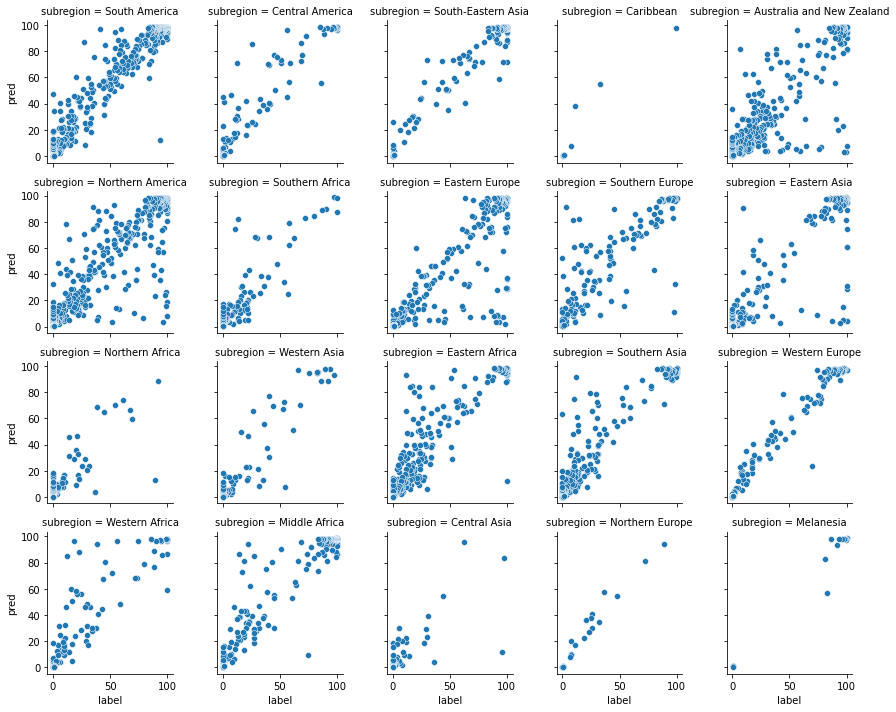

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X_plot = np.linspace(0, 100, 100)
Y_plot = X_plot
g = sns.FacetGrid(df, col="subregion", height=2.5, col_wrap=5)
g.map(sns.scatterplot, "label", "pred")
#g.map(sns.lineplot, X_plot, Y_plot)
#plt.plot(X_plot, Y_plot, color='r')
#plt.show()
#plt.figure(figsize=(7,7))
#sns.jointplot(x = df.label, y = df.pred, kind = 'hist', vmax = 20)

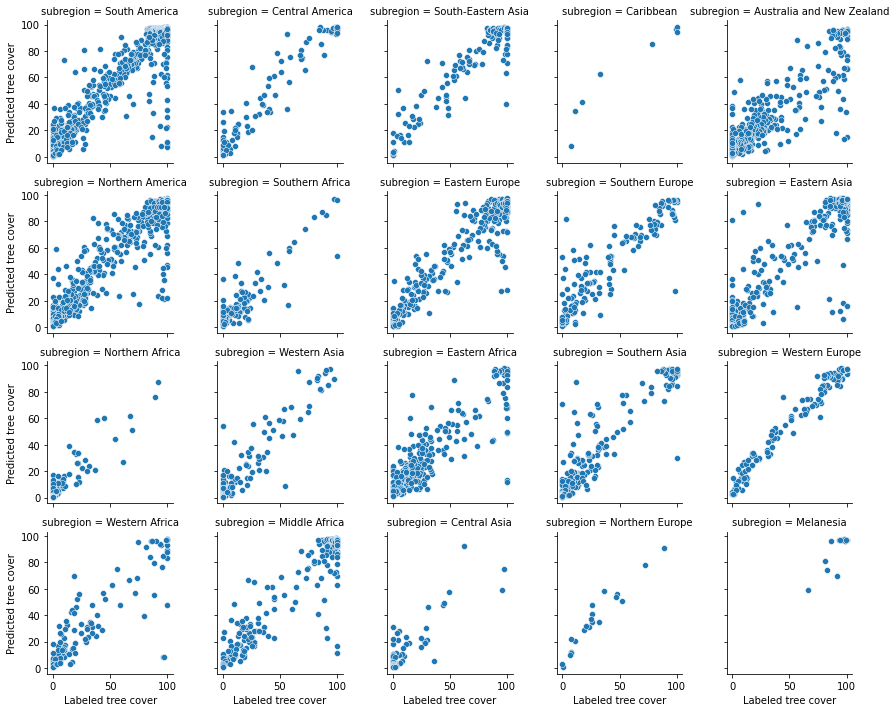

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X_plot = np.linspace(0, 100, 100)
Y_plot = X_plot
g = sns.FacetGrid(df, col="subregion", height=2.5, col_wrap=5)
g.map(sns.scatterplot, "label", "preds")
g.set(ylabel = 'Predicted tree cover', xlabel = 'Labeled tree cover')
#g.map(sns.lineplot, X_plot, Y_plot)
#plt.plot(X_plot, Y_plot, color='r')
#plt.show()
#plt.figure(figsize=(7,7))
#sns.jointplot(x = df.label, y = df.pred, kind = 'hist', vmax = 20)

In [2]:


%run ../src/preprocessing/indices.py

In [3]:
#predict_model_path = "../models/75-composite-masterfeb9/"
predict_model_path = "../models/regressor-75/"


In [4]:
predict_graph_def = tf.compat.v1.GraphDef()
if os.path.exists(predict_model_path):
    print(f"Loading model from {predict_model_path}")
    predict_file = tf.io.gfile.GFile(predict_model_path + "predict_graph.pb", 'rb')
    predict_graph_def.ParseFromString(predict_file.read())
    predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
    predict_sess = tf.compat.v1.Session(graph=predict_graph)
    predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/conv2d_13/Sigmoid:0") 
    #predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/clip_by_value:0") 
    #feature_extraction = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0")  
    #feature_extraction_initial = predict_sess.graph.get_tensor_by_name(
    #    "predict/conv_median_drop/drop_block2d_1/cond/Merge:0")
    predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
    predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")
else:
    raise Exception(f"The model path {predict_model_path} does not exist")

Loading model from ../models/regressor-75/


In [5]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 
           0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 
           0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434,
           0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

In [6]:

def convert_to_db(x: np.ndarray, min_db: int) -> np.ndarray:
    """ Converts unitless backscatter coefficient
        to db with a min_db lower threshold
        
        Parameters:
         x (np.ndarray): unitless backscatter (T, X, Y, B) array
         min_db (int): integer from -50 to 0
    
        Returns:
         x (np.ndarray): db backscatter (T, X, Y, B) array
    """
    
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = (x + min_db) / min_db
    return np.clip(x, 0, 1)

In [7]:
import pandas as pd
source = 'train'
x = hkl.load(f"../data/{source}/{source}_x.hkl")
test_y = hkl.load(f"../data/{source}/{source}_y.hkl")
df = pd.read_csv(f"../data/{source}/{source}_plot_ids.csv")
x = np.delete(x, 11, -1)
x = x[:len(df)]
test_y = test_y[:len(df)]
print(len(df))

5291


'\nnotree = [3, 420, 442, 533, 775, 855, 943, 1050, 1051,\n        1150, 1237, 1249, 1258, 1308, 1401]\n\ntest_y[notree, :7, :7] = 0.\nvalid_treecover = [19,   52,  307,  348,  399,  430,  585,  631,  671,  679,  961,\n       1024, 1144, 1240, 1365, 1376, 1386]\n\ntrees_remove = [32, 216, 363, 472, 504, 540, 622, 708, 758, 779, 791,\n        920, 921, 934, 946, 1020,  1094,1124,  1183, 1228, 1330,\n        1342, 1375, 1398 ]\n\nvalid_treecover = valid_treecover + trees_remove\n\nx = np.delete(x, valid_treecover, 0)\ntest_y = np.delete(test_y, valid_treecover, 0)\ndf = df.drop(valid_treecover)\nprint(x.shape)\n'

In [8]:
x = np.float32(x) / 65535

x[..., -1] = convert_to_db(x[..., -1], 22)
x[..., -2] = convert_to_db(x[..., -2], 22)

indices = np.zeros((x.shape[0], 12, 28, 28, 4), dtype = np.float32)
indices[..., 0] = evi(x)
indices[..., 1] = bi(x)
indices[..., 2] = msavi2(x)
indices[..., 3] = grndvi(x)

x = np.concatenate([x, indices], axis = -1)

In [9]:
idx = 0
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def preprocess_sample(test, idx):

    med = np.median(test[idx], axis = 0)
    med = med[np.newaxis, :, :, :]
    sample = np.concatenate([test[idx], med], axis = 0)
    
    for band in range(0, sample.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        sample[..., band] = np.clip(sample[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (sample[..., band] - midrange) / (rng / 2)
        sample[..., band] = standardized
    return sample


In [10]:
len(df)

5291

In [11]:
idx = len(x) - 32


In [31]:
df.to_csv("../data/train-csv/chm/chm-master-output.csv", index = False)

In [29]:
df['error'] = (df['preds'])  - (df['label'])
#df.to_csv("../data/train-csv/chm/chm-2018-2017-error.csv", index = False)

In [11]:
df.label = [0] * len(df)
df.pred = [0] * len(df)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.transform
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation
preds_y = np.zeros_like(test_y)
#from skimage.transform import resize
idx =  0#len(x) - 112
for i in range(idx, len(test_y)):
    #print(idx, df.iloc[idx])
    sample = preprocess_sample(x, idx)
    output_smp = np.zeros((28, 28))
    #sample = skimage.transform.resize(sample, (13, 28*2, 28*2, 17), 1)
    
    batch_x = sample[np.newaxis]
    lengths = np.full((batch_x.shape[0]), 12)
    preds = predict_sess.run(predict_logits,
                          feed_dict={predict_inp:batch_x, 
                                     predict_length:lengths})
    preds_y[i] = preds.squeeze()
    #df.label[i] = np.mean(test_y[idx] / 2.55)
    #df.pred[i] = np.mean(preds) * 100
    
    #     mean_x)
    #if i % 20 == 0:
    abserror = ((np.mean(preds) * 100) - np.mean(test_y[i] / 2.55))#df.label[i])
    #abserror_old = abs(df.error[i])
    if abs(abserror) > 40:
        print(idx, df.iloc[idx]['lat'],  df.iloc[idx]['lon'], abserror)# df.iloc[idx]['error']),
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))

        sns.heatmap(preds.squeeze(), vmin = 0.0, vmax = 1, ax=ax1, cbar = False)
        sns.heatmap(test_y[idx], vmin = 0.0, vmax = 255, ax=ax2, cbar = False)
        plt.show()
    idx += 1
    
# 11016080031, 12842060020, 14708050020,  5297110020, 4503060040, 9183080040, 3152050010
# 4554080030, 

In [17]:
np.corrcoef(preds_y.flatten(), test_y.flatten())

array([[1.        , 0.89244915],
       [0.89244915, 1.        ]])

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


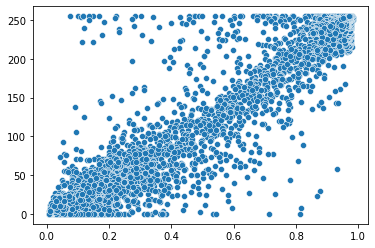

In [16]:
sns.scatterplot(np.mean(preds_y[:5000], axis = (1, 2)), np.mean(test_y[:5000], axis = (1, 2)),)

In [21]:
df['preds'] = np.mean(preds_y, axis = (1, 2)) * 100
df['label'] = np.mean(test_y, axis = (1, 2)) / 2.55